In [90]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import math as m
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
import warnings 
warnings.filterwarnings(action="ignore")

Using TensorFlow backend.


# LSTM Forecast

In [91]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [92]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

In [93]:
# root mean squared error or rmse
def measure_rmse(actual, predicted): 
	plt.plot(actual,color='red',label='Actual') 
	plt.plot(predicted,color='green',label='Predicted') 
	plt.legend()    
	plt.show()
	return sqrt(mean_squared_error(actual, predicted))


In [94]:
# difference dataset
def difference(data, interval):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [95]:
# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))   
	model.add(Dense(n_nodes, activation='relu')) 
	model.add(Dense(n_nodes, activation='relu'))  
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))   
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

In [96]:
# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)  
	return correction + yhat[0]

In [97]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error


In [98]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=3):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

In [99]:
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

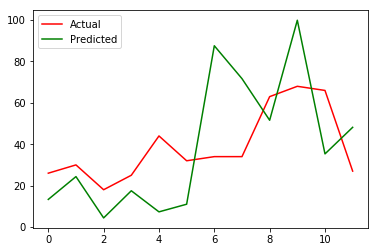

 > 27.471


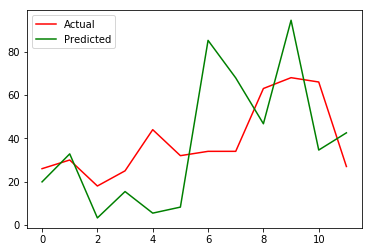

 > 26.407


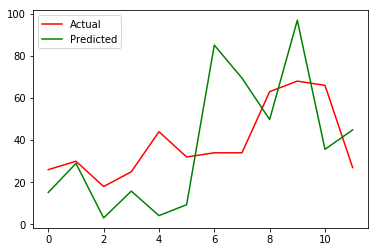

 > 26.823
lstm: 26.900 RMSE (+/- 0.438)


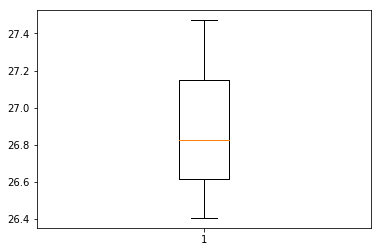

In [100]:
# Read the data into dataframe
series = pd.read_csv("C:/Users/Moaz Nabeel/Desktop/Time_Series_data.csv",header=0,index_col=0)
data = series.values

# data split
n_test = 12

# define config
config = [10, 250, 300, 200, 12]

# grid search
scores = repeat_evaluate(data, config, n_test)

# summarize scores
summarize_scores('lstm', scores)

# cfg_list=[10, 250, 300, 200, 12]

# # grid search
# scores = grid_search(data, cfg_list, n_test)
# print('done')

# # list top 10 configs
# for cfg, error in scores[:10]:
# 	print(cfg, error)

# ConvLSTM: A combination of CNNs and LSTMs where the LSTM units read input data using the convolutional process of a CNN.

In [6]:
# evaluate cnn lstm
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	plt.plot(actual,color='red',label='Actual') 
	plt.plot(predicted,color='green',label='Predicted') 
	plt.legend()    
	plt.show()
	return sqrt(mean_squared_error(actual, predicted))
 
# fit a model
def model_fit(train, config):
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
	n_input = n_seq * n_steps
	# prepare data
	data = series_to_supervised(train, n_in=n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
	# define model
	model = Sequential()
	model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None,n_steps,1))))
	model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model
 
# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error
 
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=3):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores
 
# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()
 


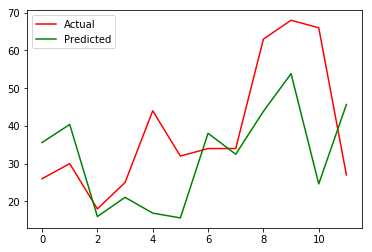

 > 17.957


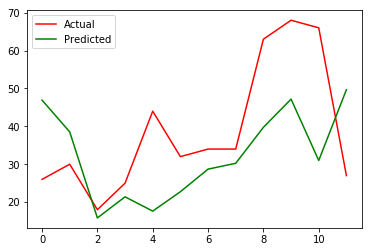

 > 18.405


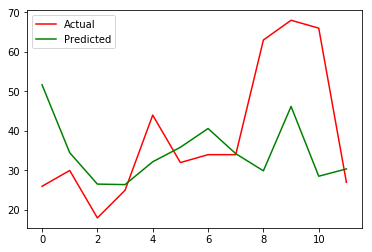

 > 18.114
cnn-lstm: 18.159 RMSE (+/- 0.186)


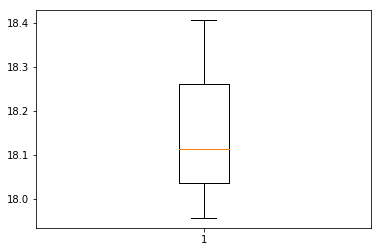

In [7]:
series = pd.read_csv("C:/Users/Moaz Nabeel/Desktop/Time_Series_data.csv",header=0,index_col=0)
data = series.values

# data split
n_test = 12
# define config
config = [3, 12, 64, 3, 100, 300, 200]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

n_seq: The number of subsequences within a sample. 

n_steps: The number of time steps within each subsequence. 

n_filters: The number of parallel filters.

n_kernel: The number of time steps considered in each read of the input sequence.

n_nodes: The number of LSTM units to use in the hidden layer.

n_epochs: The number of times to expose the model to the whole training dataset.

n_batch: The number of samples within an epoch after which the weights are updated.


# EDA

In [101]:
# Augmented Dickey-Fuller test to check if our data is stationary or not 
from pandas import Series
from statsmodels.tsa.stattools import adfuller
series = Series.from_csv("C:/Users/Moaz Nabeel/Desktop/Time_Series_data.csv", header=0)
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
# results show that the data is stationary since our p value in less than 0.05

ADF Statistic: -4.146829
p-value: 0.000810
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


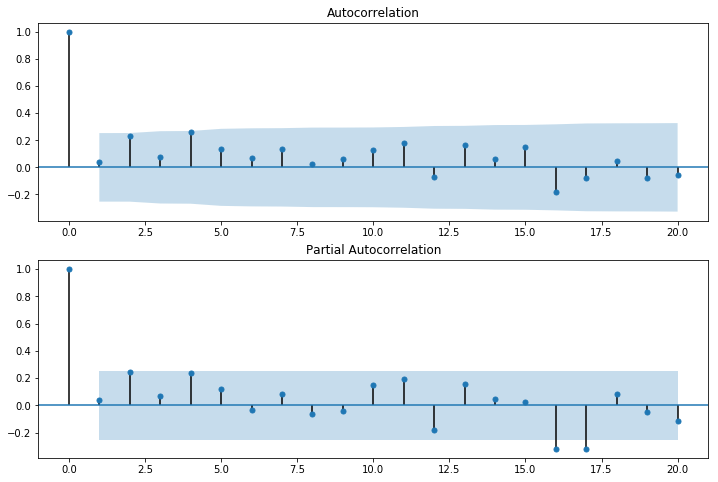

In [52]:
# Classic ACF and PACF Plots for Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(X, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(X, lags=20, ax=ax2)

# The plots below show there is not autocorrelation 

In [103]:
from pandas.core.window import rolling
def plot_rolling2(timeseries, window):
    rol_mean =timeseries.rolling(window, min_periods = 1).mean()
    rol_std =timeseries.rolling(window, min_periods = 1).std()
    
    fig = plt.figure(figsize = (12, 8))
    og = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rol_mean, color = "red", label = "Rolling Mean")
    std = plt.plot(rol_std, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation (window = "+str(window)+")")
    plt.show()

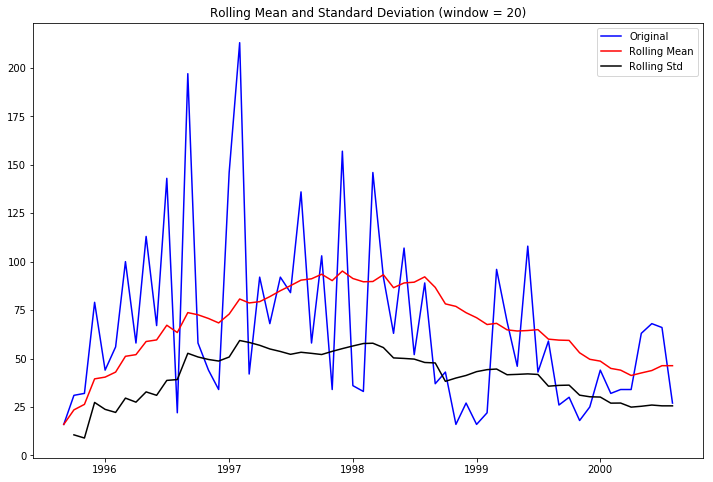

In [104]:
plot_rolling2(series,20)

# FBProphet Forecast

In [61]:
import pandas as pd
import pystan
from fbprophet import Prophet
df = pd.read_csv("C:/Users/Moaz Nabeel/Desktop/Time_Series_data.csv")
df=df.iloc[0:48,:]
df.tail(5)

,dates,demand
43,4/1/1999,69
44,5/1/1999,46
45,6/1/1999,108
46,7/1/1999,43
47,8/1/1999,59


In [62]:
df['dates'] = pd.DatetimeIndex(df['dates'])
df = df.rename(columns={'dates': 'ds', 'demand': 'y'})
df.head(5)

,ds,y
0,1995-09-01,16
1,1995-10-01,31
2,1995-11-01,32
3,1995-12-01,79
4,1996-01-01,44


In [63]:
my_model = Prophet(interval_width=0.99)

In [64]:
my_model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Moaz Nabeel\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [65]:
future_dates = my_model.make_future_dataframe(periods=12, freq='MS')
future_dates.tail(12)

,ds
48,1999-09-01
49,1999-10-01
50,1999-11-01
51,1999-12-01
52,2000-01-01
53,2000-02-01
54,2000-03-01
55,2000-04-01
56,2000-05-01
57,2000-06-01


In [87]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
55,2000-04-01,70.722586,-36.971691,172.736196
56,2000-05-01,65.320288,-39.319385,167.011139
57,2000-06-01,85.773439,-11.450681,183.228695
58,2000-07-01,73.558532,-26.899212,180.021951
59,2000-08-01,68.131072,-30.554315,177.774581


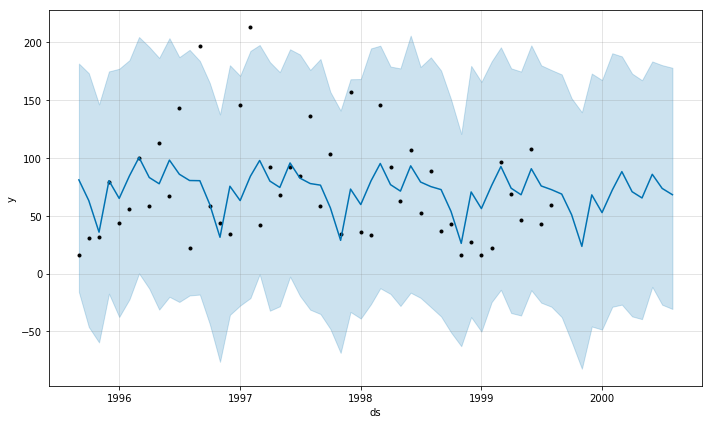

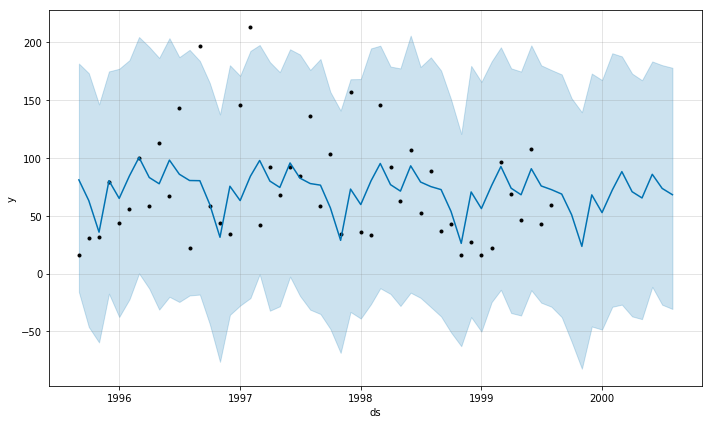

In [88]:
my_model.plot(forecast,uncertainty=True)

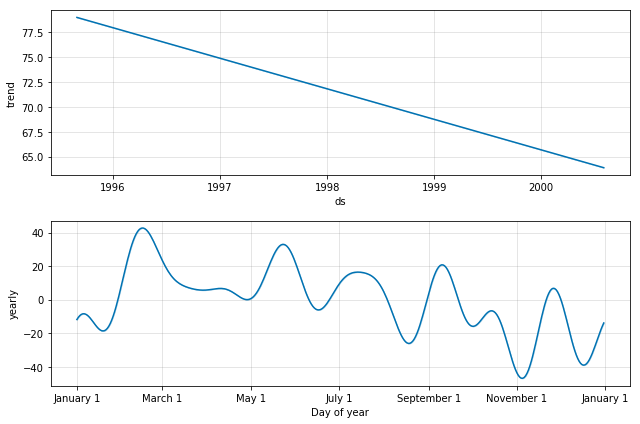

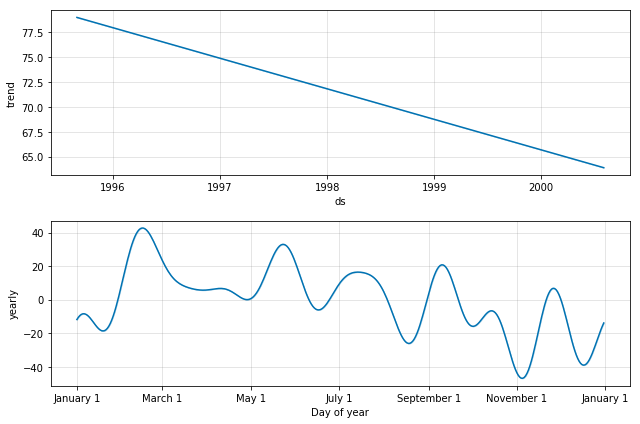

In [89]:
my_model.plot_components(forecast)

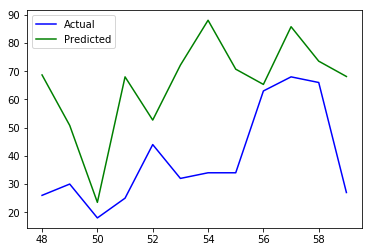

RMSE: 31.836065707649603


In [90]:
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("C:/Users/Moaz Nabeel/Desktop/Time_Series_data.csv")
df2=df.iloc[48:,:]
df2.head(5)




plt.plot(df2.demand, color='blue',label='Actual')
plt.plot(forecast.yhat[48:], color='green',label='Predicted')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
y_actual=df2.demand
y_predicted=forecast.yhat[48:]
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_actual,y_predicted))))

# Seasonal ARIMA Forecast 

In [281]:
y= pd.read_csv("C:/Users/Moaz Nabeel/Desktop/Time_Series_data.csv",header=0, index_col='dates',parse_dates=True)
y.head()


,demand
dates,
1995-09-01,16
1995-10-01,31
1995-11-01,32
1995-12-01,79
1996-01-01,44


In [282]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [283]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [284]:
# warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:687.3766147908893
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:527.1537424473912
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:526.3735485042299
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1314.8530929703259
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:534.0130309334206
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:504.569831441329
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:389.9090141620332
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1462.4064974824848
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:660.833444613154
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:509.82345191806314
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:516.4708248102897
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1207.404190231143
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:535.9800643091758
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:494.382997257623
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:391.7793356629853
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1182.5018093259148
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:645.6894307019575
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:503.6405466715938
ARIMA(0, 

In [285]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0757      0.124     -0.612      0.540      -0.318       0.166
ma.L1         -1.0000    666.528     -0.002      0.999   -1307.371    1305.371
ar.S.L12      -0.3775      0.105     -3.596      0.000      -0.583      -0.172
sigma2      2030.2277   1.35e+06      0.001      0.999   -2.65e+06    2.65e+06


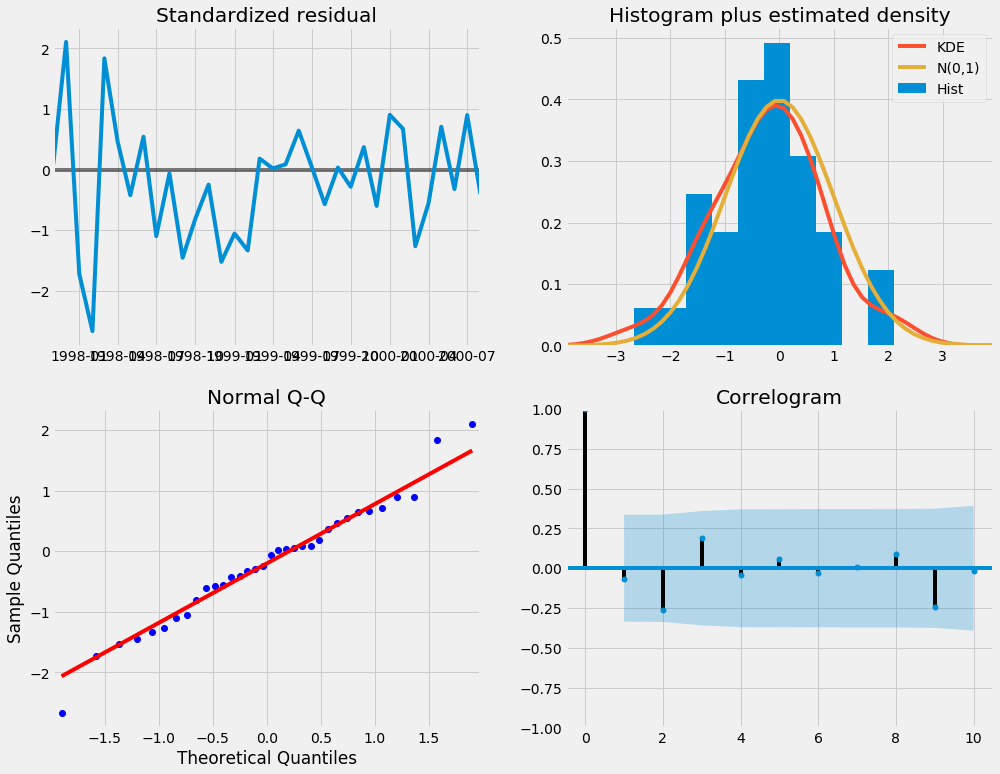

In [286]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [318]:
pred = results.get_prediction(start=pd.to_datetime('1999-9-1'), dynamic=False)
pred_ci = pred.conf_int()


1999-09-01    24.516027
1999-10-01    43.117376
1999-11-01     1.021570
1999-12-01    52.596745
2000-01-01     2.585450
2000-02-01     1.210065
2000-03-01    92.066950
2000-04-01    59.556571
2000-05-01    30.676230
2000-06-01    82.758532
2000-07-01    24.896508
2000-08-01    45.520707
Freq: MS, dtype: float64

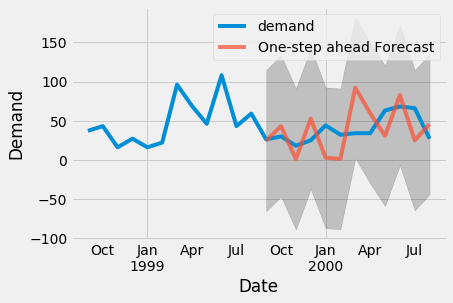

In [305]:
ax = y['1998-9-1':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [321]:
y_forecasted = pred.predicted_mean
y_truth = y.demand.iloc[48:]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Mean Squared Error of our forecasts is 933.95
The Root Mean Squared Error of our forecasts is 30.56


In [326]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1999-09-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

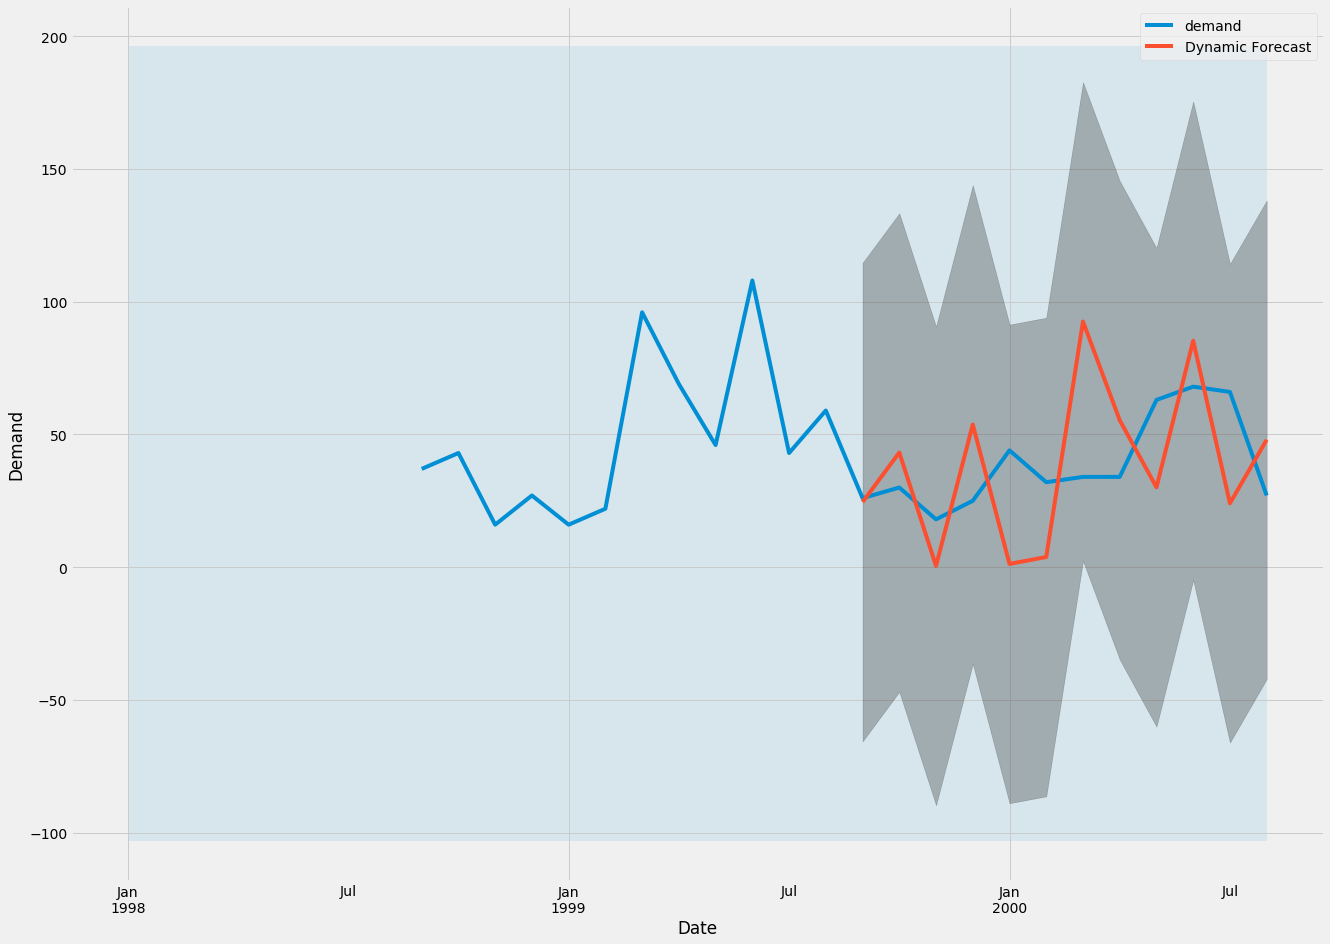

In [327]:
ax = y['1998-9-1':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
plt.show()

In [329]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y.demand.iloc[48:]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 949.82
The Root Mean Squared Error of our forecasts is 30.82


In [333]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

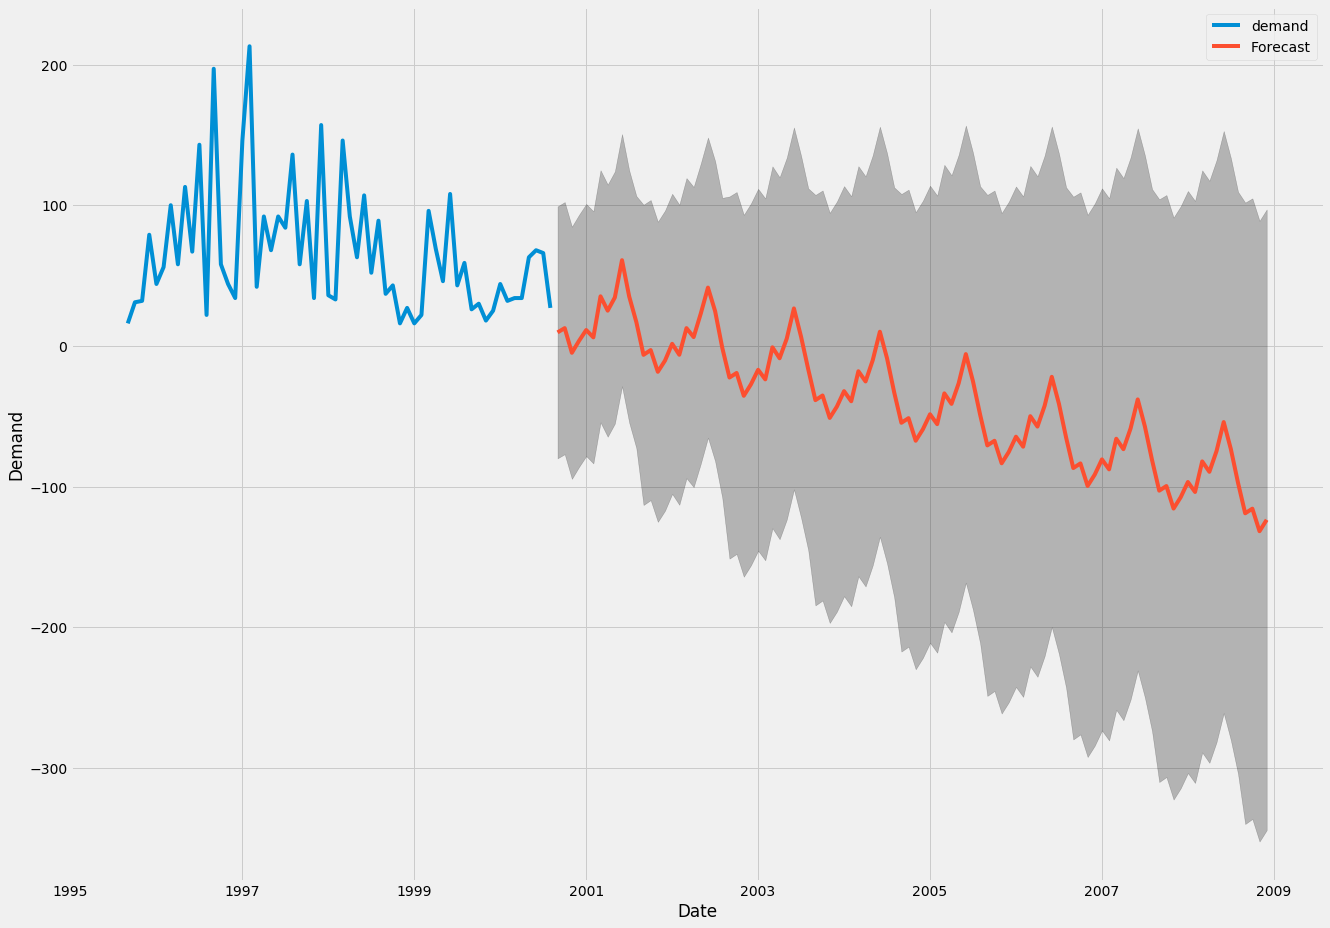

In [337]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')

plt.legend()
plt.show()

# Simple Arima Forecast 

predicted=50.468677, expected=26.000000
predicted=46.464772, expected=30.000000
predicted=27.824860, expected=18.000000
predicted=25.242570, expected=25.000000
predicted=20.813870, expected=44.000000
predicted=33.060180, expected=32.000000
predicted=39.669256, expected=34.000000
predicted=33.147407, expected=34.000000
predicted=34.365026, expected=63.000000
predicted=46.444382, expected=68.000000
predicted=66.271049, expected=66.000000
predicted=68.458520, expected=27.000000
Test MSE: 378.456
Test RMSE: 19.454


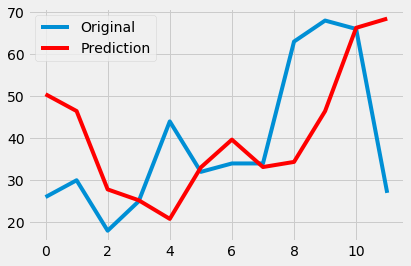

In [322]:


from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot


series = read_csv("C:/Users/Moaz Nabeel/Desktop/Time_Series_data.csv", header=0, index_col=0, squeeze=True)

X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % np.sqrt(error))
# plot
pyplot.plot(test,label='Original')
pyplot.plot(predictions, color='red',label='Prediction')
pyplot.legend()
pyplot.show()

# Simple Exponential Smoothing

In [70]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

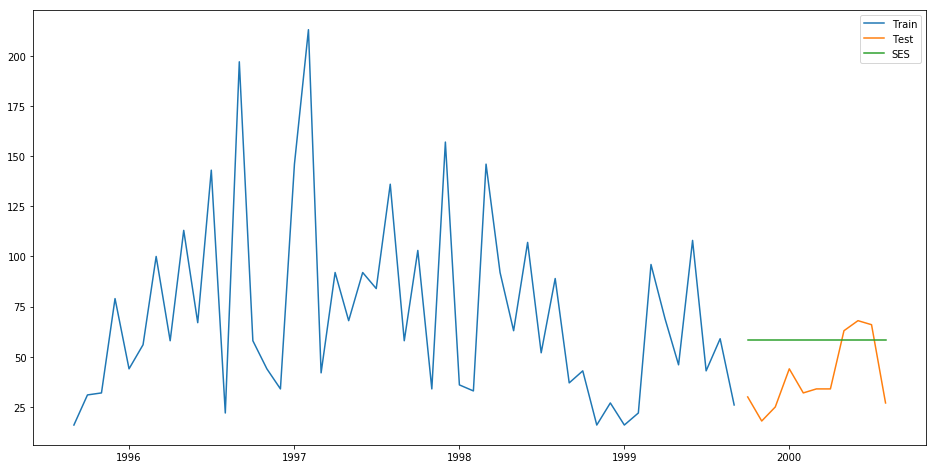

In [71]:
df= pd.read_csv("C:/Users/Moaz Nabeel/Desktop/Time_Series_data.csv",header=0, index_col='dates',parse_dates=True)


train=df[0:49] 
test=df[49:]


y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['demand'])).fit(smoothing_level=0.1,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['demand'], label='Train')
plt.plot(test['demand'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [72]:
rms = np.sqrt(mean_squared_error(test.demand, y_hat_avg.SES))
print(rms)

24.809773894848767


# Holt's Linear Trend

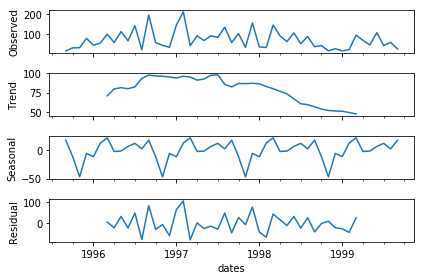

In [64]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.demand).plot()
result = sm.tsa.stattools.adfuller(train.demand)
plt.show()

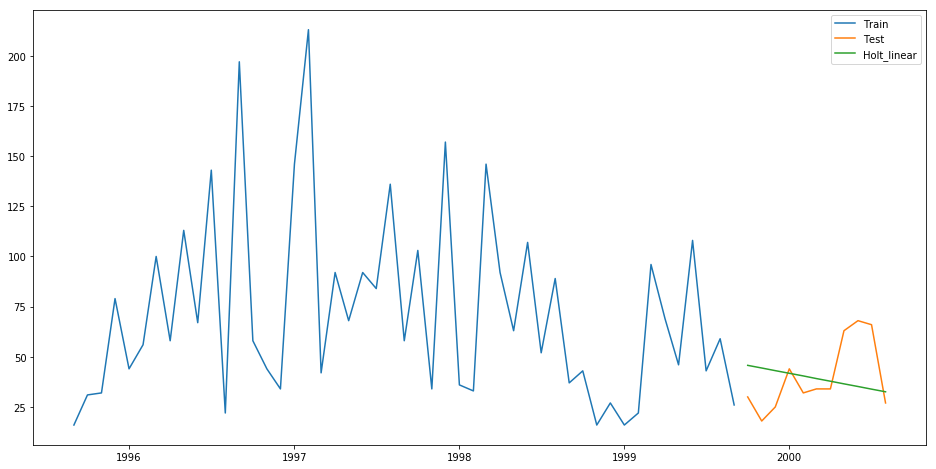

In [83]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['demand'])).fit(smoothing_level = 0.4,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['demand'], label='Train')
plt.plot(test['demand'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [84]:
rms = np.sqrt(mean_squared_error(test.demand, y_hat_avg.Holt_linear))
print(rms)

19.61107596999921


# Holt's Winter Method

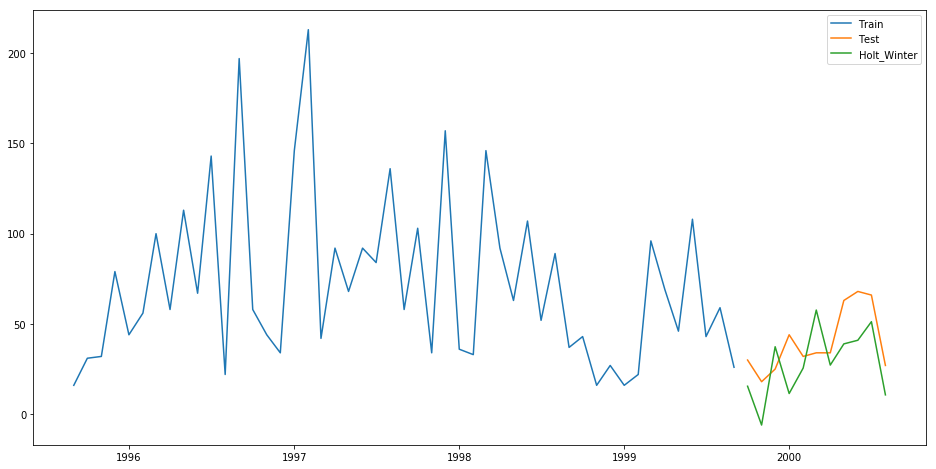

In [88]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['demand']) ,seasonal_periods=12,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['demand'], label='Train')
plt.plot(test['demand'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [89]:
rms = np.sqrt(mean_squared_error(test.demand, y_hat_avg.Holt_Winter))
print(rms)

20.090463465267902
